In [1]:
import numpy as np
import pandas as pd
import os
import gc
import time
from contextlib import contextmanager
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read in Data

In [2]:
# Liste des fichiers disponibles
print(os.listdir('./input/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# Lire le fichier de description de colonne
columns_description = pd.read_csv('./input/HomeCredit_columns_description.csv', encoding='latin1')
columns_description.shape

(219, 5)

In [4]:
# Affiche les 5 premières colonnes
print(columns_description.head())

   Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN  


In [5]:
# Données d'entraînement
app_train = pd.read_csv('./input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d'apprentissage comportent 30 7511 observations (chacune étant un prêt distinct) et 122 caractéristiques (variables), y compris le `TARGET` (l'étiquette que nous voulons prédire).

In [6]:
# Données de test
app_test = pd.read_csv('./input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


L'ensemble de test est considérablement plus petit et ne comporte pas de colonne `TARGET`.

# Analyse exploratoire des données

## Examiner la distribution de la colonne cible

La cible est ce que l'on nous demande de prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement.

In [7]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

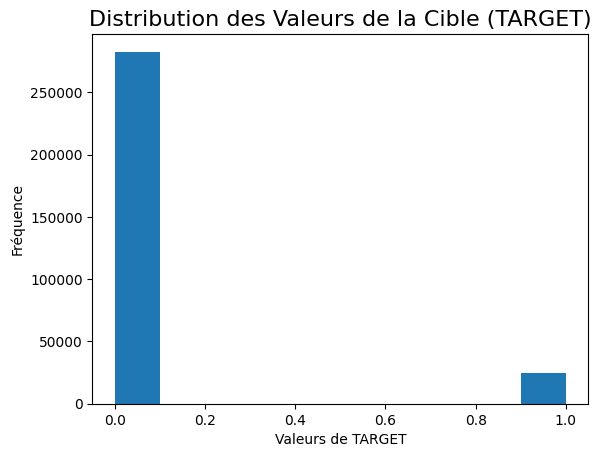

In [8]:
app_train['TARGET'].astype(int).plot.hist()

# Ajouter un titre
plt.title("Distribution des Valeurs de la Cible (TARGET)", fontsize=16)

# Ajouter des étiquettes pour les axes si nécessaire
plt.xlabel('Valeurs de TARGET')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()

Ces informations montrent qu'il s'agit d'un problème de classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.

## Examiner les valeurs manquantes

In [9]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total des valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Créer un tableau avec les résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renommer les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Trier le tableau par pourcentage de valeurs manquantes en ordre décroissant
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Imprimer quelques informations récapitulatives
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Retourne le dataframe avec les informations manquantes
        return mis_val_table_ren_columns

In [10]:
# Statistiques sur les valeurs manquantes
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


Lorsqu'il s'agira de construire nos modèles d'apprentissage automatique, nous devrons compléter ces valeurs manquantes (ce que l'on appelle l'imputation). Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. Par conséquent, nous conserverons toutes les colonnes pour l'instant.

## Column Types

In [11]:
# Nombre de chaque type de colonne
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [12]:
# Nombre de classes uniques dans chaque colonne d'objets
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encoder les variables catégorielles

Pour toute variable catégorielle (dtype == objet) comportant 2 catégories uniques, nous utiliserons le codage par étiquette, et pour toute variable catégorielle comportant plus de 2 catégories uniques, nous utiliserons le codage à une touche.

In [13]:
# Créer un objet encodeur d'étiquettes
le = LabelEncoder()
le_count = 0

# Itérer à travers les colonnes
for col in app_train:
    if app_train[col].dtype == 'object':
        # Si 2 catégories uniques ou moins
        if len(list(app_train[col].unique())) <= 2:
            # Entraîner sur les données d'entraînement
            le.fit(app_train[col])
            # Transformer les données d'entraînement et de test
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Suivre le nombre de colonnes encodées avec des étiquettes
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [14]:
# Codage à une touche de variables catégorielles
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [15]:
train_labels = app_train['TARGET']

# Aligner les données d'entraînement et de test, ne conserver que les colonnes présentes dans les deux dataframe
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Ajouter la cible
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## Anomalies

Les chiffres de la colonne `DAYS_BIRTH` sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année.

In [16]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Description de `DAYS_BIRTH` : Âge du client en jours au moment de la demande
Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure.

In [17]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Description de `DAYS_EMPLOYED` : Combien de jours avant la demande la personne a-t-elle commencé son emploi actuel ?
A propos des jours d'emploi : Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

Text(0.5, 0, 'Days Employment')

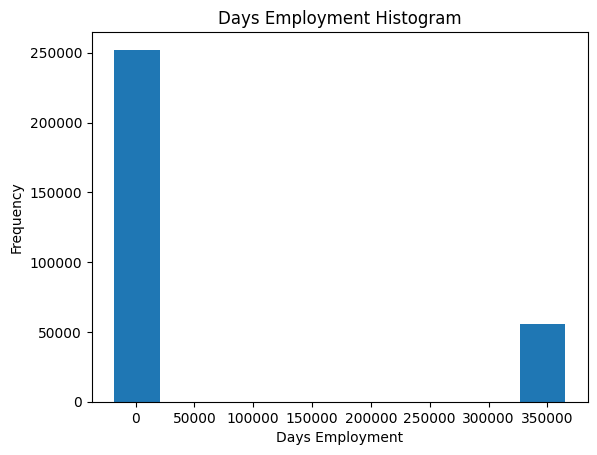

In [18]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [19]:
anomalies = app_train[app_train['DAYS_EMPLOYED'] > 300000]
unique_values_counts = anomalies['DAYS_EMPLOYED'].value_counts()
print(unique_values_counts)

DAYS_EMPLOYED
365243    55374
Name: count, dtype: int64


Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [20]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Il s'avère que les anomalies ont un taux de défaillance plus faible.
Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Pour ce faire, nous remplissons les valeurs anormales avec not a number (np.nan) et créons ensuite une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

Text(0.5, 0, 'Days Employment')

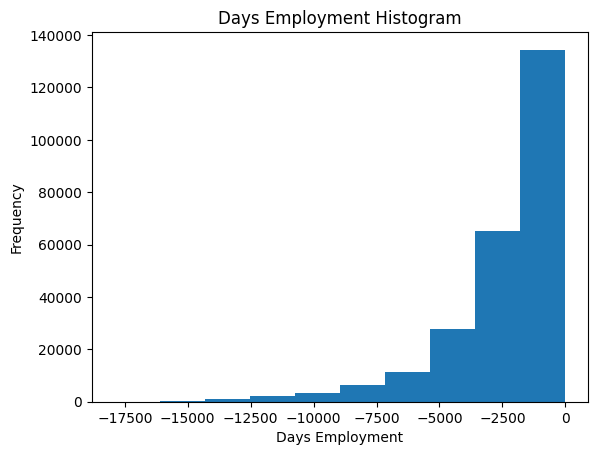

In [21]:
# Créer une colonne d'anomalies
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales par nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales. Les autres colonnes contenant des jours dans le cadre de données semblent correspondre à ce que nous attendons et ne présentent pas de valeurs aberrantes évidentes.

Créez la nouvelle colonne et remplissez la colonne existante avec np.nan dans les données de test.

In [22]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


## Corrélations

Calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode .corr dataframe.

In [23]:
# Trouver les corrélations avec la cible et les trier
correlations = app_train.corr()['TARGET'].sort_values()

# Afficher les corrélations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

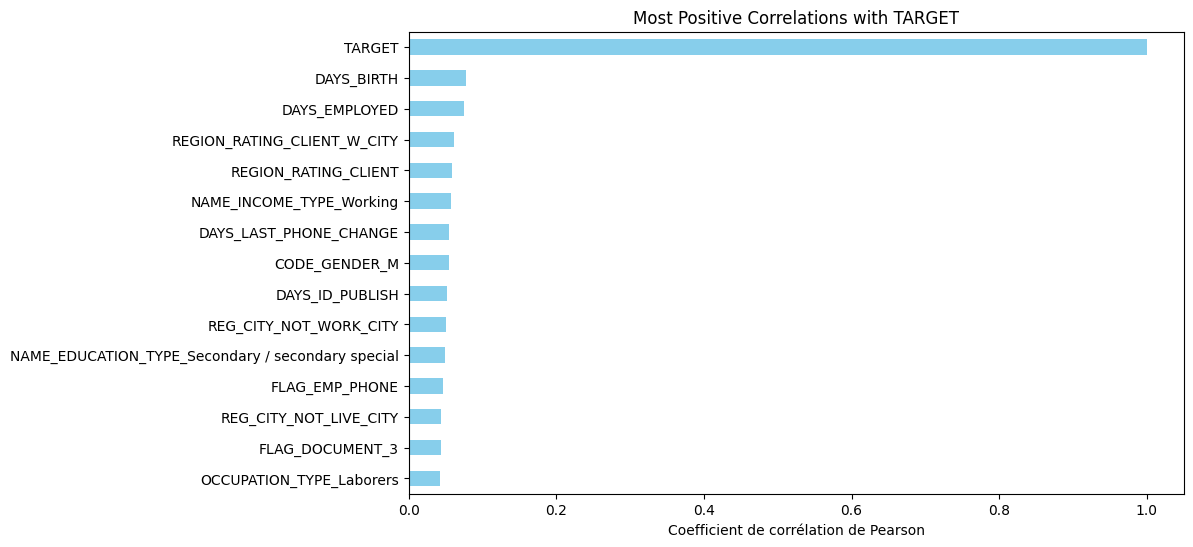

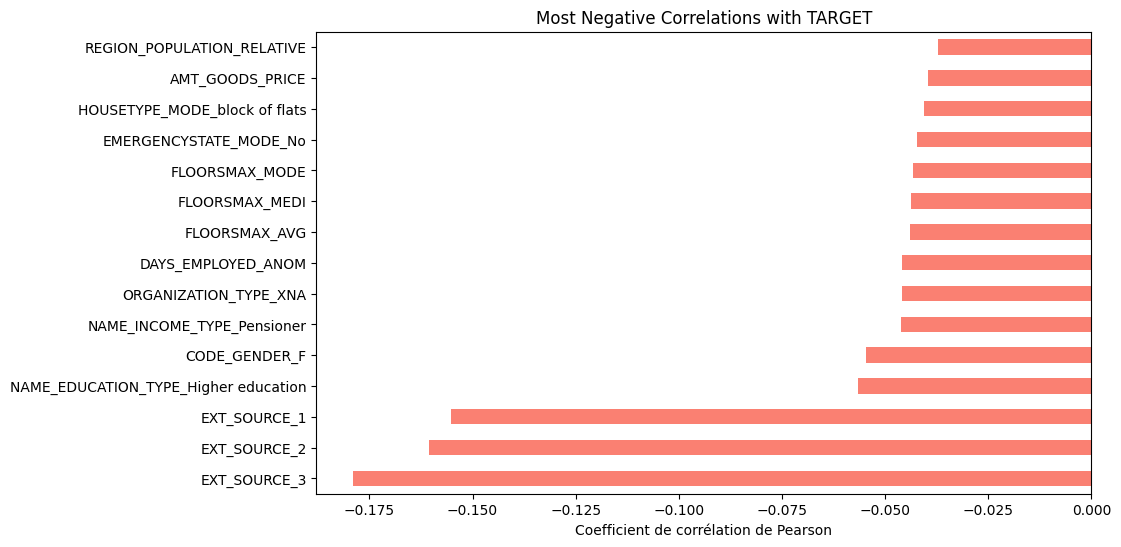

In [24]:
# Afficher les 15 corrélations les plus positives et les plus négatives
plt.figure(figsize=(10, 6))
correlations.tail(15).plot(kind='barh', color='skyblue')
plt.title('Most Positive Correlations with TARGET')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.show()

plt.figure(figsize=(10, 6))
correlations.head(15).plot(kind='barh', color='salmon')
plt.title('Most Negative Correlations with TARGET')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.show()

`Interprétation`
r = 1 : Corrélation positive parfaite.
r = −1 : Corrélation négative parfaite.
r = 0 : Aucune corrélation linéaire.

La corrélation la plus positive est `DAYS_BIRTH`. Si l'on regarde la documentation, `DAYS_BIRTH` est l'âge en jours du client au moment du prêt, en jours négatifs. La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt. C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera alors négative.

In [25]:
# Trouver la corrélation entre le nombre de jours positifs depuis la naissance et la cible.
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982692)

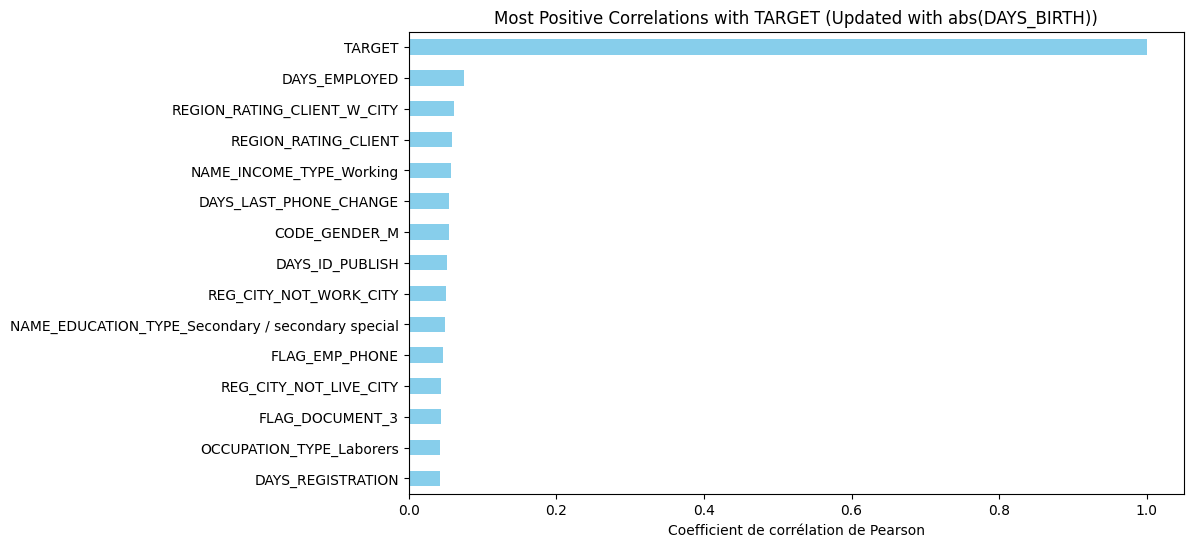

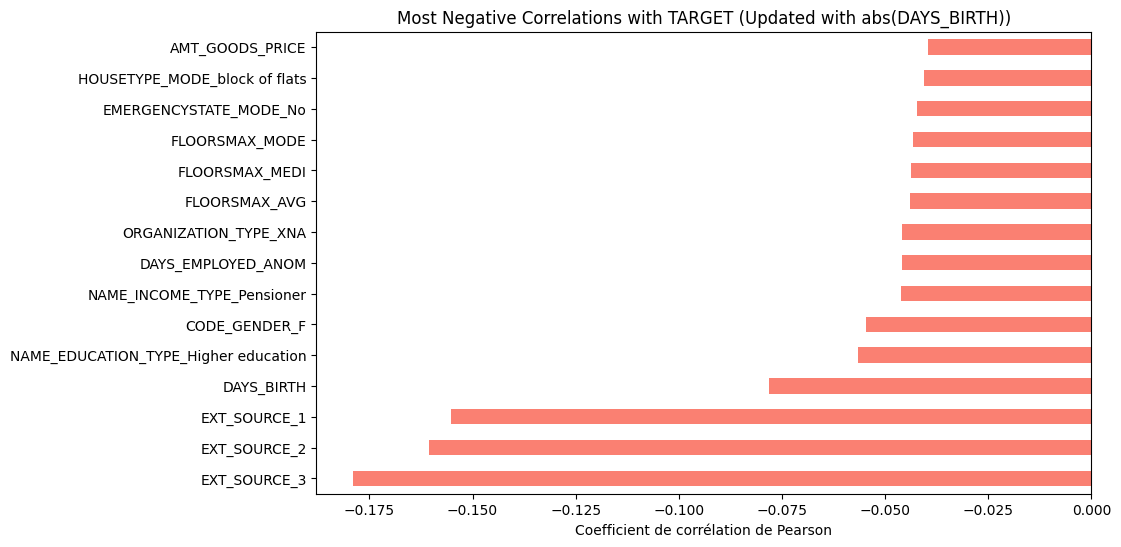

In [26]:
# Prendre la valeur absolue de 'DAYS_BIRTH' avant de recalculer la corrélation
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

# Recalculer les corrélations avec 'TARGET'
correlations = app_train.corr()['TARGET'].sort_values()

# Afficher les 15 corrélations les plus positives et les plus négatives
plt.figure(figsize=(10, 6))
correlations.tail(15).plot(kind='barh', color='skyblue')
plt.title('Most Positive Correlations with TARGET (Updated with abs(DAYS_BIRTH))')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.show()

plt.figure(figsize=(10, 6))
correlations.head(15).plot(kind='barh', color='salmon')
plt.title('Most Negative Correlations with TARGET (Updated with abs(DAYS_BIRTH))')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.show()

Plus le client est âgé, plus il existe une relation linéaire négative avec l'objectif, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps.

Text(0, 0.5, 'Count')

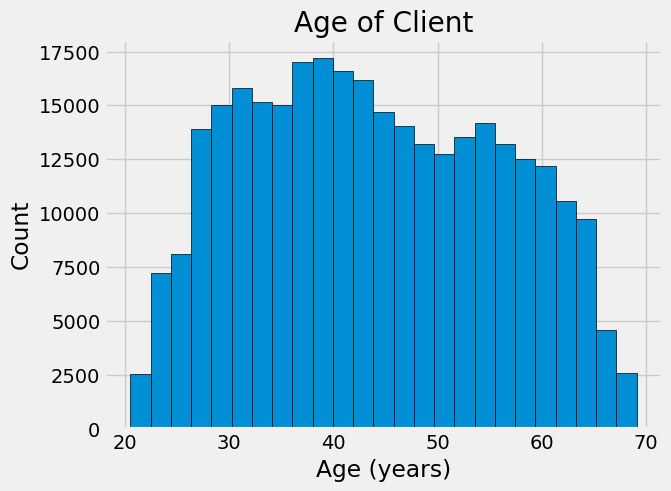

In [27]:
# Définir le style des graphiques
plt.style.use('fivethirtyeight')

# Tracer la distribution des âges en années
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous ferons ensuite un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible.

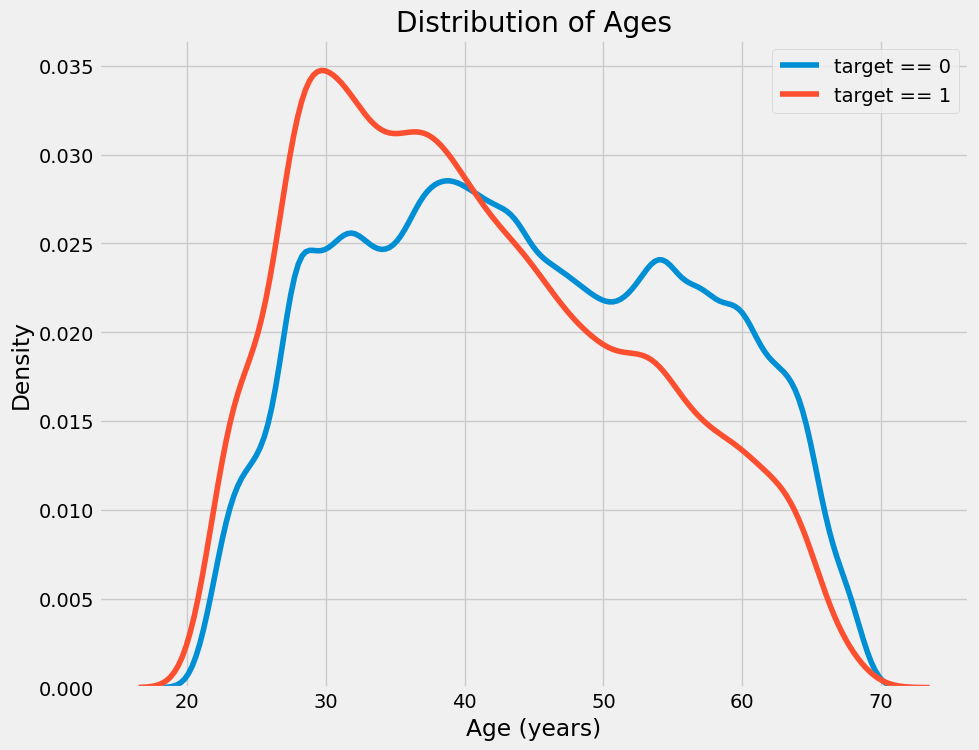

In [28]:
plt.figure(figsize=(10, 8))

# Graphique KDE des prêts qui ont été remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target == 0')

# Graphique KDE des prêts qui n'ont pas été remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target == 1')

# Étiquetage du graphique
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

# Ajout de la légende
plt.legend()

plt.show()

La courbe de la cible == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge.

In [29]:
# Informations sur l'âge dans un dataframe séparé
age_data = app_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin les données d'âge
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [30]:
# Regrouper par bin et calculer les moyennes
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

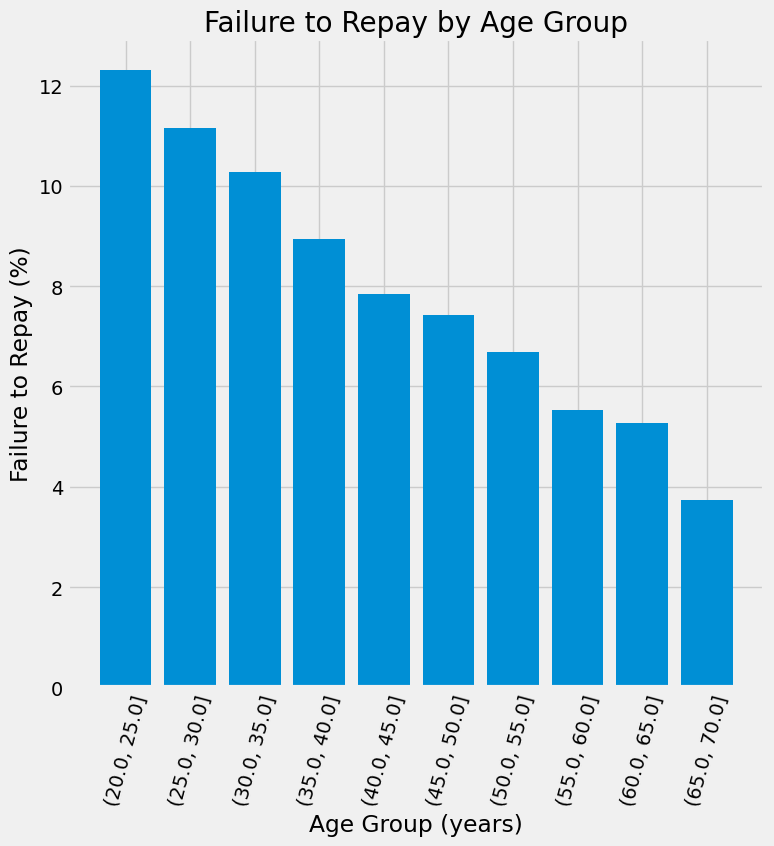

In [31]:
plt.figure(figsize = (8, 8))

# Graphique des tranches d'âge et de la moyenne de la cible sous la forme d'un diagramme à barres
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Tracer l'étiquetage
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

Les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Les trois variables présentant les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2` et `EXT_SOURCE_3`. D'après la documentation, ces caractéristiques représentent un "score normalisé provenant d'une source de données externe". Annalysons les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [32]:
# Extraire les variables EXT_SOURCE et montrer les corrélations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

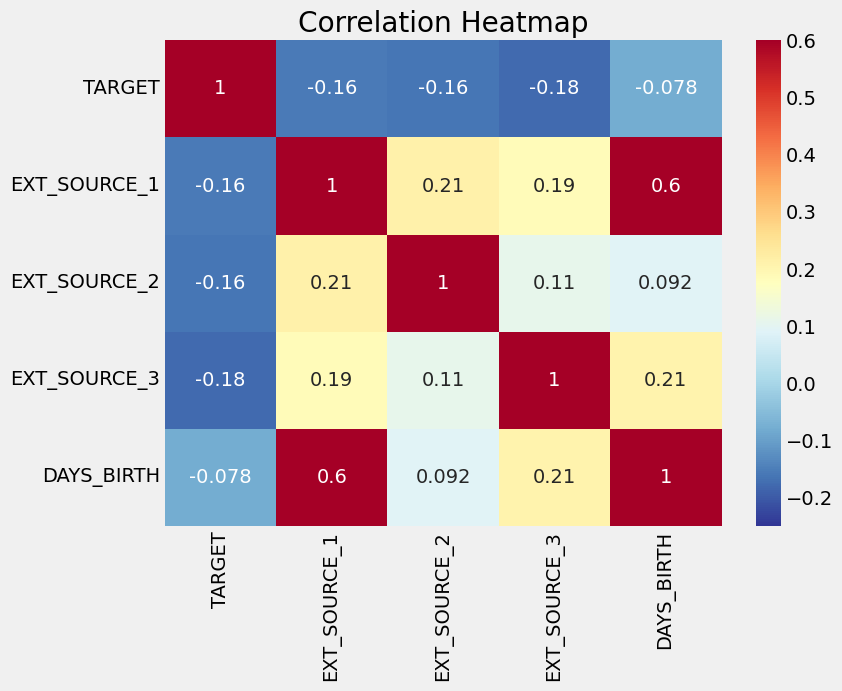

In [33]:
plt.figure(figsize = (8, 6))

# Heatmap des corrélations
sns.heatmap(ext_data_corrs, cmap='RdYlBu_r', vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

Les trois caractéristiques `EXT_SOURCE` ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'`EXT_SOURCE` augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1`, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

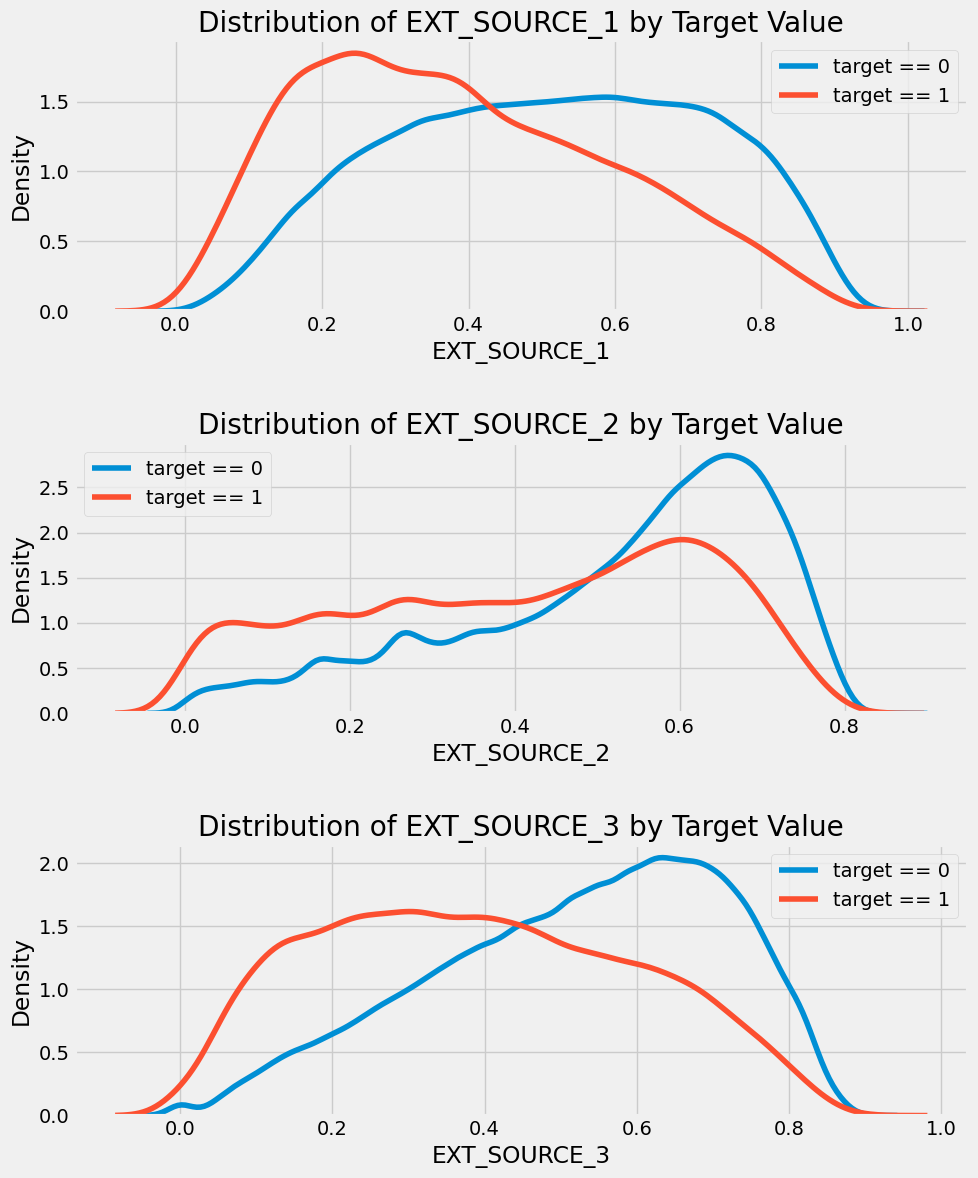

In [34]:
plt.figure(figsize=(10, 12))

# Itérer à travers les sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Créer un nouveau sous-graphe pour chaque source
    plt.subplot(3, 1, i + 1)
    # Tracer les prêts remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target == 0')
    # Tracer les prêts qui n'ont pas été remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target == 1')
    
    # Etiqueter les graphes
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    
    # Ajouter une légende
    plt.legend()

plt.tight_layout(h_pad=2.5)

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles), mais ces variables seront toujours utiles à un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt dans les délais.

Réalisation un diagramme de paires entre les variables `EXT_SOURCE` et la variable `DAYS_BIRTH`.

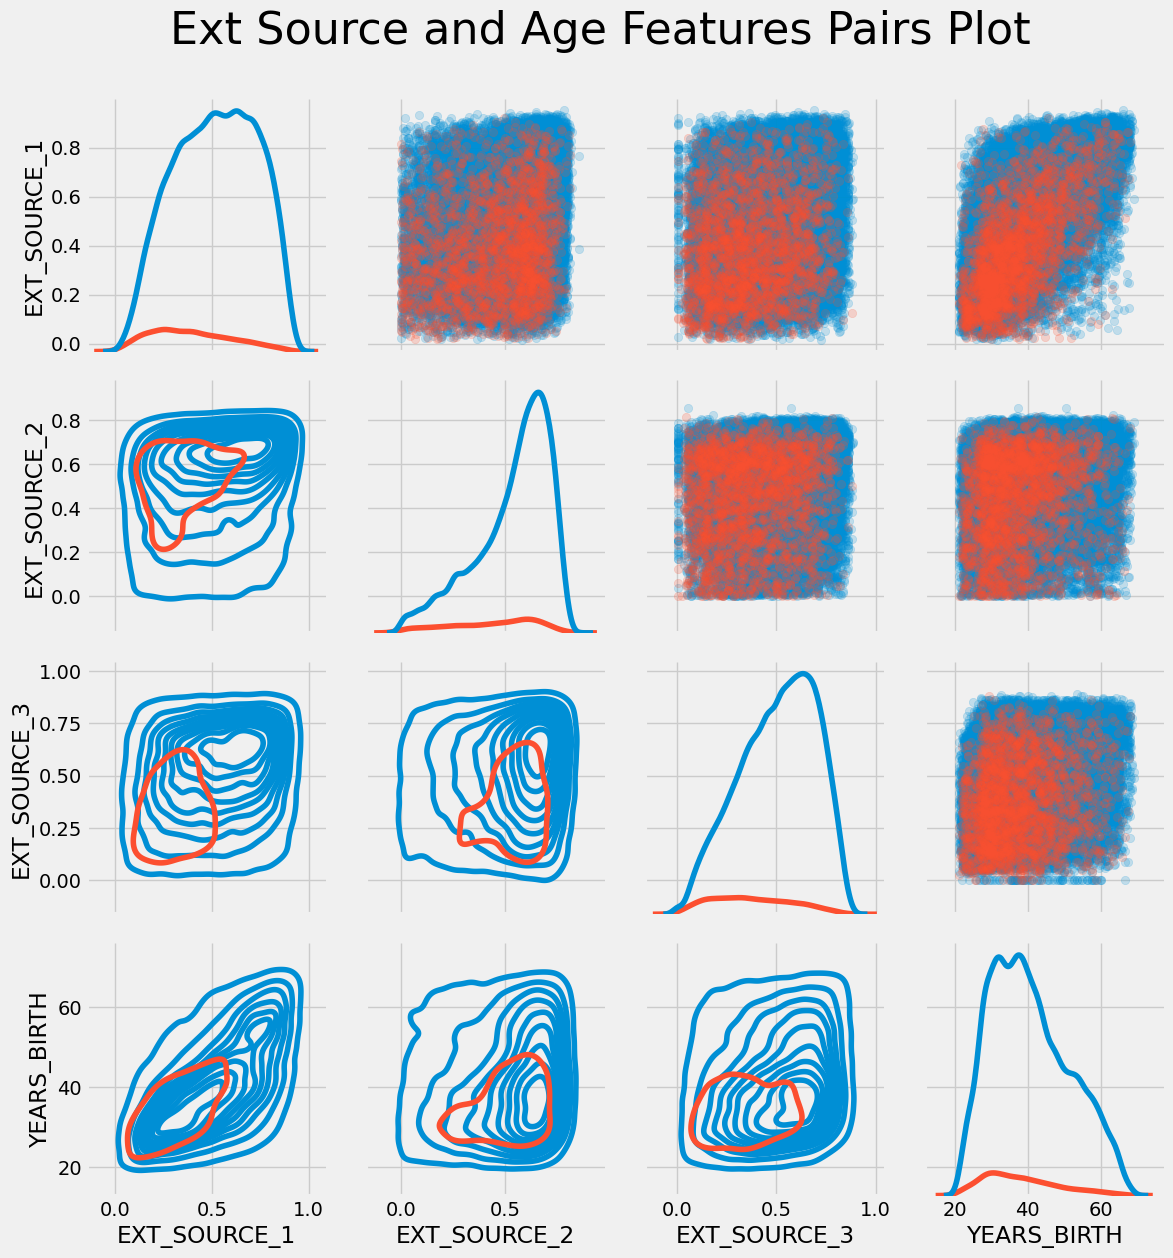

In [35]:
# Copier les données pour le tracé
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Ajouter l'âge du client en années
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Supprimer les valeurs na et se limiter aux 100000 premières lignes
plot_data = plot_data.dropna().loc[:100000, :]

# Fonction pour calculer le coefficient de corrélation entre deux colonnes
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate(f"r = {r:.2f}", xy=(.2, .8), xycoords=ax.transAxes, size=20)

# Créer l'objet pairgrid
grid = sns.PairGrid(data=plot_data, height=3, diag_sharey=False,
                    hue='TARGET', 
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])

# Le haut est un nuage de points
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonal est un graphique KDE
grid.map_diag(sns.kdeplot)

# Le bas est un graphe de densité
grid.map_lower(sns.kdeplot)

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)
plt.show()

Dans ce graphique, le rouge indique les prêts non remboursés et le bleu les prêts remboursés. Nous pouvons voir les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre `EXT_SOURCE_1` et `YEARS_BIRTH`, ce qui indique que cette caractéristique peut prendre en compte l'âge du client.

# Feature Engineering

Pour évaluer l'efficacité de nos étapes de traitement des données et de feature engineering, nous utilisons une fonction de minuterie (`timer`). Cette fonction, implémentée avec le décorateur `@contextmanager`, nous permet de mesurer et d'afficher le temps d'exécution de chaque bloc de code. Cela nous aide à identifier les étapes potentiellement optimisables et à assurer une gestion efficace du temps de calcul.

In [36]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

Dans nos données, les variables catégorielles ne peuvent pas être directement utilisées par les modèles de machine learning. Pour les rendre utilisables, nous appliquons une technique appelée *One-Hot Encoding*. Cette méthode transforme chaque catégorie unique d'une variable catégorielle en une nouvelle colonne binaire. Chaque colonne correspond à une catégorie, et prend la valeur 1 si l'observation appartient à cette catégorie, et 0 sinon. 

La fonction `one_hot_encoder` utilise la méthode `pd.get_dummies` de Pandas pour effectuer cet encodage, en ajoutant également une colonne pour les valeurs manquantes si `nan_as_category` est défini sur True. Cela nous permet de traiter efficacement les données catégorielles et de les intégrer dans nos modèles.

In [37]:
# Encodage à une touche pour les colonnes catégorielles avec get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

1. **Chargement et Fusion des Données** :  
   Les données des fichiers d'entraînement et de test sont chargées et fusionnées pour uniformiser le traitement. Nous utilisons les DataFrames `app_train` et `app_test` préalablement modifiés dans l'analyse exploratoire.

2. **Création de Nouvelles Caractéristiques** :  
   - **Création de Caractéristiques Basées sur les Ratios** :
     - `DAYS_EMPLOYED_PERC` : proportion de jours employés par rapport à l'âge du client.
     - `INCOME_CREDIT_PERC` : proportion du revenu total par rapport au crédit accordé.
     - `INCOME_PER_PERSON` : revenu total par membre de la famille.
     - `ANNUITY_INCOME_PERC` : proportion de l'annuité par rapport au revenu total.
     - `PAYMENT_RATE` : taux de paiement, défini comme le montant de l'annuité divisé par le crédit total.
     - `GOODS_CREDIT_RATIO` : proportion du prix des biens par rapport au crédit.
     - `CREDIT_PER_FAM_MEMBER` : nombre de crédits par membre de la famille.
     - `AVG_FAM_MEMBER_AGE` : âge moyen des membres de la famille.
     - `CREDIT_INQUIRIES_INCOME_RATIO` : nombre d'enquêtes de crédit par rapport au revenu total.

   - **Caractéristiques Basées sur l'Âge et le Score Externe** :
     - `YEARS_BIRTH` : l'âge du client en années (calculé à partir de `DAYS_BIRTH`).
     - `AGE_GROUP` : classification des clients par tranche d'âge. Cette variable permet d'examiner les différences de comportement en fonction de l'âge des clients.

   - **Interactions entre l'Âge et les Scores Externes** :
     - `EXT_SOURCE_1_YEARS_BIRTH` : interaction entre la caractéristique `EXT_SOURCE_1` et l'âge du client.
     - `EXT_SOURCE_2_YEARS_BIRTH` : interaction entre la caractéristique `EXT_SOURCE_2` et l'âge du client.
     - `EXT_SOURCE_3_YEARS_BIRTH` : interaction entre la caractéristique `EXT_SOURCE_3` et l'âge du client.

   - **Caractéristiques Agrégées et Ratios Basés sur les Scores Externes** :
     - `EXT_SOURCE_MEAN` : moyenne des trois caractéristiques externes (`EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`). Cette caractéristique fournit une vue d'ensemble des scores externes pour chaque client.
     - `EXT_SOURCE_1_DIV_EXT_SOURCE_2` : ratio entre `EXT_SOURCE_1` et `EXT_SOURCE_2`.
     - `EXT_SOURCE_1_DIV_EXT_SOURCE_3` : ratio entre `EXT_SOURCE_1` et `EXT_SOURCE_3`.
     - `EXT_SOURCE_2_DIV_EXT_SOURCE_3` : ratio entre `EXT_SOURCE_2` et `EXT_SOURCE_3`.
     - `CREDIT_EXT_SOURCE_MEAN` : ratio entre le montant du crédit (`AMT_CREDIT`) et la moyenne des scores externes.

Ces caractéristiques sont conçues pour capturer des relations et des interactions importantes entre les différentes variables du dataset, telles que l'âge, les scores externes et les montants de crédit, afin d'améliorer les performances des modèles de machine learning.

In [38]:
# Prétraitement de application_train.csv et application_test.csv
def application_train_test(app_train, app_test):
    # Fusionner les données d'entraînement et de test pour un traitement ultérieur
    df = pd.concat([app_train, app_test], ignore_index=True)

    # Quelques nouvelles caractéristiques simples (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['GOODS_CREDIT_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
    df['CREDIT_PER_FAM_MEMBER'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
    df['AVG_FAM_MEMBER_AGE'] = (df['DAYS_BIRTH'] / df['CNT_FAM_MEMBERS']) / -365
    df['CREDIT_INQUIRIES_INCOME_RATIO'] = (
        df['AMT_REQ_CREDIT_BUREAU_HOUR'] + df['AMT_REQ_CREDIT_BUREAU_DAY'] +
        df['AMT_REQ_CREDIT_BUREAU_WEEK'] + df['AMT_REQ_CREDIT_BUREAU_MON'] +
        df['AMT_REQ_CREDIT_BUREAU_QRT'] + df['AMT_REQ_CREDIT_BUREAU_YEAR']) / df['AMT_INCOME_TOTAL']

    # Feature Engineering basée sur l'analyse des corrélations
    # Convertir DAYS_BIRTH en valeurs positives et en années
    df['YEARS_BIRTH'] = abs(df['DAYS_BIRTH']) / 365

    # Regroupement par tranche d'âge
    df['AGE_GROUP'] = pd.cut(df['YEARS_BIRTH'], bins=[20, 30, 40, 50, 60, 70, 80], labels=[1, 2, 3, 4, 5, 6])

    # Créer des caractéristiques d'interaction entre EXT_SOURCE et YEARS_BIRTH
    df['EXT_SOURCE_1_YEARS_BIRTH'] = df['EXT_SOURCE_1'] * df['YEARS_BIRTH']
    df['EXT_SOURCE_2_YEARS_BIRTH'] = df['EXT_SOURCE_2'] * df['YEARS_BIRTH']
    df['EXT_SOURCE_3_YEARS_BIRTH'] = df['EXT_SOURCE_3'] * df['YEARS_BIRTH']

    # Créer la caractéristique agrégée EXT_SOURCE
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

    # Créer des caractéristiques de ratio impliquant EXT_SOURCE
    df['EXT_SOURCE_1_DIV_EXT_SOURCE_2'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['EXT_SOURCE_1_DIV_EXT_SOURCE_3'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']
    df['EXT_SOURCE_2_DIV_EXT_SOURCE_3'] = df['EXT_SOURCE_2'] / df['EXT_SOURCE_3']

    # Créer une interaction entre CREDIT et EXT_SOURCE
    df['CREDIT_EXT_SOURCE_MEAN'] = df['AMT_CREDIT'] / df['EXT_SOURCE_MEAN']

    gc.collect()
    return df

1. **Chargement et Encodage des Données** : Les données sont chargées et les variables catégorielles sont encodées en utilisant la méthode One-Hot Encoding, ce qui permet de convertir les catégories en colonnes binaires.

2. **Agrégation des Données Bureau Balance** : Les données de `bureau_balance` sont agrégées pour chaque crédit (`SK_ID_BUREAU`) en calculant des statistiques comme `min`, `max`, et `mean`. Ces agrégations sont ensuite jointes aux données `bureau` sur la clé `SK_ID_BUREAU`.

3. **Agrégation des Données Bureau** : Les données `bureau` sont agrégées sur les clients (`SK_ID_CURR`) en utilisant plusieurs statistiques pour des variables numériques comme `DAYS_CREDIT`, `AMT_CREDIT_SUM`, etc. Des agrégations séparées sont effectuées pour les crédits actifs et fermés, ce qui permet de différencier les comportements en fonction de l'état du crédit.

4. **Traitement des Catégories** : Les variables catégorielles sont également agrégées en utilisant des moyennes pour capturer les tendances spécifiques aux catégories.

Ces agrégations et traitements permettent de synthétiser les informations complexes des fichiers `bureau` et `bureau_balance` en un ensemble de caractéristiques utilisables pour la modélisation.

In [39]:
# Prétraitement de bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('./input/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('./input/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance : Effectuer les agrégations et fusionner avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    
    # Caractéristiques numériques de bureau et de bureau_balance
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Caractéristiques catégorielles du bureau et de bureau_balance
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau : Crédits actifs - en utilisant uniquement des agrégations numériques
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau : Crédits clôturés - en utilisant uniquement des agrégations numériques
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

1. **Chargement et Encodage des Données** : Les données sont chargées et les variables catégorielles sont encodées en utilisant la méthode One-Hot Encoding. Cela permet de convertir les catégories en variables numériques binaires.

2. **Gestion des Valeurs Anormales** : Les valeurs `365.243` dans les colonnes liées aux dates (`DAYS_FIRST_DRAWING`, `DAYS_FIRST_DUE`, `DAYS_LAST_DUE_1ST_VERSION`, etc.) sont remplacées par `NaN` car elles indiquent des anomalies.

3. **Création de Nouvelles Caractéristiques** : Une nouvelle caractéristique, `APP_CREDIT_PERC`, est ajoutée. Elle représente le pourcentage du montant de la demande de crédit par rapport au crédit accordé, ce qui peut être un indicateur de la solvabilité du client.

4. **Agrégation des Caractéristiques Numériques** : Les données numériques sont agrégées sur les clients (`SK_ID_CURR`) en utilisant des statistiques telles que le minimum, le maximum, et la moyenne pour des variables comme `AMT_ANNUITY`, `AMT_APPLICATION`, `AMT_CREDIT`, etc.

5. **Agrégation des Demandes Approuvées et Refusées** : Des agrégations séparées sont effectuées pour les demandes approuvées et refusées. Ces agrégations permettent de capturer les tendances et les comportements spécifiques associés à l'approbation ou au refus des demandes de crédit.

Ces étapes permettent de synthétiser les informations détaillées des applications précédentes en un ensemble de caractéristiques utilisables pour la modélisation, tout en traitant les anomalies et en encapsulant des informations critiques sur le comportement de crédit des clients.

In [40]:
# Prétraitement de previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('./input/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Ajout d'une feature : pourcentage de valeur demandée / valeur reçue
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Feature numériques des demandes précédentes
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Applications précédentes features catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Demandes antérieures : Demandes approuvées - uniquement les features numériques
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # # Demandes antérieures : Demandes refusées - uniquement les features numériques
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

1. **Chargement et Encodage des Données** : Les données sont chargées, et les variables catégorielles sont encodées en utilisant la méthode One-Hot Encoding, convertissant ainsi les catégories en variables binaires.

2. **Agrégation des Caractéristiques** :
   - Les agrégations sont effectuées sur des variables clés telles que `MONTHS_BALANCE`, `SK_DPD`, et `SK_DPD_DEF`. Les agrégations incluent des statistiques comme le maximum, la moyenne, et la taille (`size`). Cela permet de résumer l'activité de crédit et le comportement de paiement des clients.
   - `MONTHS_BALANCE` indique le nombre de mois de solde en arriéré.
   - `SK_DPD` et `SK_DPD_DEF` représentent respectivement le nombre de jours de retard et le nombre de jours de défaut.
   
3. **Comptage des Comptes POS Cash** : Une nouvelle caractéristique, `POS_COUNT`, est ajoutée pour représenter le nombre de comptes de crédit à la consommation associés à chaque client. Cela peut être un indicateur de l'exposition au crédit du client.

Ces transformations et agrégations permettent de capturer des informations cruciales sur le comportement de crédit des clients dans le contexte des transactions de points de vente et de crédit à la consommation. Ces caractéristiques sont ensuite utilisées pour enrichir le modèle prédictif.

In [41]:
# Prétraitement POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('./input/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Compter les POS_COUNT (comptes de caisse)
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

1. **Chargement et Encodage des Données** : Les données sont chargées, et les variables catégorielles sont encodées en utilisant la méthode One-Hot Encoding. Cela permet de convertir les catégories en colonnes binaires.

2. **Calcul des Ratios de Paiement et des Différences** :
   - `PAYMENT_PERC` : Ce ratio représente le pourcentage du montant payé par rapport au montant dû de chaque échéance. Il indique à quel point le client respecte ses engagements de paiement.
   - `PAYMENT_DIFF` : Cette variable calcule la différence entre le montant dû et le montant payé, permettant de voir si le client paie moins, exactement ou plus que le montant prévu.

3. **Calcul des Jours de Retard et d'Avance** :
   - `DPD` (Days Past Due) : Nombre de jours de retard dans le paiement, où les valeurs négatives sont remplacées par 0.
   - `DBD` (Days Before Due) : Nombre de jours d'avance sur le paiement, où les valeurs négatives sont également remplacées par 0.

4. **Agrégations des Caractéristiques** :
   - Les données sont agrégées sur les clients (`SK_ID_CURR`) en utilisant des statistiques telles que le maximum, la moyenne, et la somme pour des variables comme `NUM_INSTALMENT_VERSION`, `DPD`, `DBD`, `PAYMENT_PERC`, `PAYMENT_DIFF`, etc. 
   - Ces agrégations fournissent une vue d'ensemble sur le comportement de paiement des clients au fil du temps.
   
5. **Comptage des Comptes d'Échéances** : Une nouvelle caractéristique, `INSTAL_COUNT`, est ajoutée pour représenter le nombre de comptes d'échéances associés à chaque client. Cela peut indiquer l'historique et l'exposition aux paiements échelonnés du client.

Ces transformations et agrégations permettent de capturer des informations détaillées sur les comportements de paiement des clients, essentiels pour évaluer leur solvabilité et leur fiabilité financière.


In [42]:
# Prétraitement de installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('./input/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Pourcentage et différence payés dans chaque versement (montant payé et valeur du versement)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Jours de retard et jours avant échéance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Effectuer des agrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Compter les comptes de versements
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

1. **Chargement et Encodage des Données** : Les données sont chargées et les variables catégorielles sont encodées en utilisant la méthode One-Hot Encoding, ce qui permet de convertir les catégories en colonnes binaires pour une analyse plus facile.

2. **Agrégations Générales** : Les données sont agrégées sur les clients (`SK_ID_CURR`) en utilisant plusieurs statistiques telles que le minimum, le maximum, la moyenne, la somme, et la variance pour différentes variables. Cela permet de capturer des tendances importantes dans l'utilisation des cartes de crédit par les clients, comme les soldes minimum et maximum, les moyennes de dépenses, etc.

3. **Comptage des Lignes de Cartes de Crédit** : Une nouvelle caractéristique, `CC_COUNT`, est ajoutée pour représenter le nombre de lignes de cartes de crédit associées à chaque client. Cela donne une indication de l'exposition du client aux cartes de crédit.

Ces transformations permettent de résumer les informations complexes des soldes de cartes de crédit en un ensemble de caractéristiques utilisables pour le modèle prédictif. Cela aide à comprendre le comportement de crédit des clients, leur utilisation des cartes de crédit et leur gestion des soldes.

In [43]:
# Prétraitement de credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('./input/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # Agrégations générales
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Convertir les colonnes d'objets en valeurs numériques si possible, sinon remplir avec NaN
    for col in cc_agg.columns:
        if cc_agg[col].dtype == 'object':
            cc_agg[col] = pd.to_numeric(cc_agg[col], errors='coerce')
    
    # Comptez les lignes de cartes de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

1. **Chargement des Données Principales** : Les données des fichiers `application_train.csv` et `application_test.csv` sont chargées à l'aide de la fonction `application_train_test()`. Ces données contiennent les principales informations sur les clients et leurs applications de crédit.

2. **Intégration des Données Additionnelles** : Les données supplémentaires provenant des fichiers `bureau.csv`, `bureau_balance.csv`, `previous_applications.csv`, `POS_CASH_balance.csv`, `installments_payments.csv`, et `credit_card_balance.csv` sont traitées individuellement et agrégées. Chaque bloc de données est joint à l'ensemble de données principal `df` sur la clé commune `SK_ID_CURR`, permettant ainsi de regrouper toutes les informations disponibles pour chaque client.

3. **Mesure du Temps de Traitement** : Chaque étape de traitement est entourée de la fonction `timer`, qui mesure le temps pris pour chaque opération. Cela permet de suivre l'efficacité du traitement des données et d'identifier les éventuels goulets d'étranglement.

4. **Gestion de la Mémoire** : Les objets de données temporaires sont supprimés après leur utilisation pour libérer de la mémoire, ce qui est important pour traiter de grands ensembles de données sans épuiser les ressources disponibles.

5. **Imputation des Valeurs Manquantes** : Une fois que toutes les données sont intégrées dans `df`, les valeurs manquantes sont remplacées par la médiane de chaque colonne. Cette étape permet de gérer les données manquantes de manière systématique et robuste, assurant ainsi que l'ensemble de données final est complet et prêt pour la modélisation.

Cette fonction prépare un ensemble de données riche et complet en intégrant divers types d'informations sur les clients, telles que leur historique de crédit, leurs paiements d'échéances, et leur utilisation des cartes de crédit. Cela permet de créer des caractéristiques robustes pour la modélisation prédictive.

In [44]:
def main(app_train, app_test, num_rows = None):

    df = application_train_test(app_train, app_test)

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
        
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    return df

In [45]:
# Exécuter la fonction principale avec les données modifiées
df = main(app_train, app_test)

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 12s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 11s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 6s
Installments payments df shape: (339587, 26)
Process installments payments - done in 13s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 8s


In [46]:
df.to_csv('processed_data.csv', index=False)